# Import libraries

In [40]:
import sigma
import numpy as np
import hyperspy.api as hs
import matplotlib.pyplot as plt
import pyxem
import copy
import os

from sigma.utils import normalisation as norm 
from sigma.utils import visualisation as visual
from sigma.src.utils import same_seeds
from sigma.src.dim_reduction import Experiment
from sigma.models.autoencoder import AutoEncoder, VariationalAutoEncoder
from sigma.src.segmentation import PixelSegmenter
from sigma.gui import gui

##
from sigma.utils.loadsed import SEDDataset

## Load data
!!! In here we assume the data is already normalized !!!

In [61]:
file_path = "/Users/joyce/Downloads/SIGMA for Jerry/SED training data/h_dome denoise 163517.zspy"
sed_ds = SEDDataset(file_path, n_root = 1)
exclude_zero = 5

computing radial average
[########################################] | 100% Completed | 3.66 sms


## Visualize data

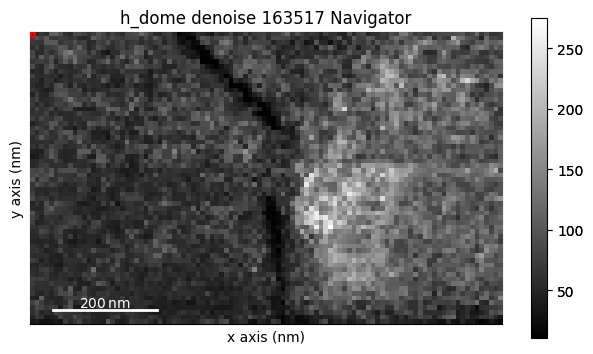

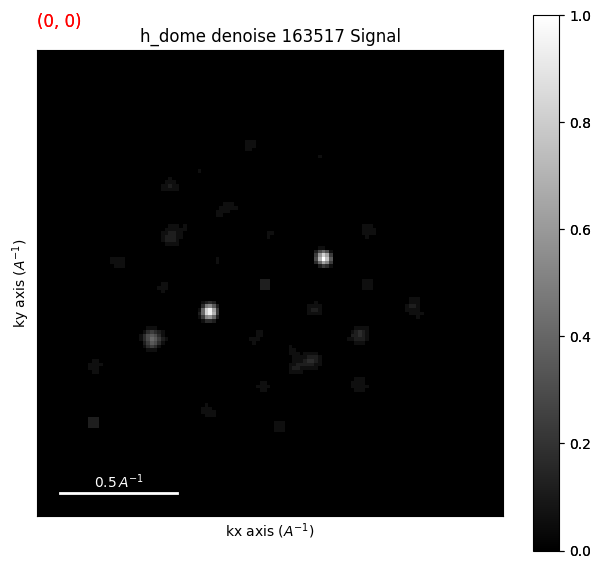

In [62]:
# plot navigator image
sed_ds.base_dataset.plot()


### 2.1.2 Training

**Parameters for `ex.run_model`**<br>
> `num_epochs`: *int*. The number of entire passes through the training dataset. 50-100 is recommonded for this value. A rule of thumb is that if the loss value stops reducing, that epoch my be a good point to stop. <br>

> `batch_size`: *int*. The number of data points per gradient update. Values between 32-128 are recommended. smaller batch size means more updates within an epoch, but is more stochastic for the optimisation process.<br>

> `learning_rate`: *float* in a range between 0-1. The learning rate controls how quickly the model is adapted to the problem. 1e-4 is recommended. Higher learning rate may yield faster convergence but have a risk to be stuck in an undesirable local minima.<br>

> `task`: *str*. if 'train_all', all data points will be used for training the autoencoder. If 'train_eval', training will be conducted on the training set (85% dataset) and testing on a testing set (15%) for evaluation. The recommended procedure is to run the 'train_eval' for hyperparameter selection, and 'train_all' for the final analysis.<br>

> `criterion`: *str*. If 'MSE', the criterion is to measure the mean squared error (squared L2 norm) between each element in the input x and target y. 'MSE' is the only option. Other criteria will be implemented in the future versions.<br>

In [72]:

# The integer in this function can determine different initialised parameters of model (tuning sudo randomness)
# This can influence the result of dimensionality reduction and change the latent space.
same_seeds(1)

# set the folder path to save the model(the model will automatically save in the specified folder)
result_folder_path='./results/trainned_models' 

if not os.path.exists(result_folder_path):
    os.makedirs(result_folder_path)
    print(f"Directory created: {result_folder_path}")
else:
    print(f"Directory already exists: {result_folder_path}")

# Set up the experiment, e.g. determining the model structure, dataset for training etc.

# Parameters to be fine tuned:
ex = Experiment(descriptor='softmax',
                general_results_dir=result_folder_path,
                model=VariationalAutoEncoder,
                model_args={'hidden_layer_sizes':(512,256,128), 'lat_dim': 3}, 
                chosen_dataset=sed_ds.spectra.data[:, :, exclude_zero:],
                save_model_every_epoch=False)

Directory already exists: ./results/trainned_models
model_name: Model-softmax
size_dataset: (62, 100, 86)
device: cpu
num_parameters: 422364


In [73]:
# Train the model
ex.run_model(num_epochs=20,
             batch_size=16,
             learning_rate=1e-5, 
             weight_decay=0.0, 
             task='train_all', 
             criterion='MSE'
            )

num_epochs: 20
batch_size: 16
task: train_all
optimizer: lr=1e-05 and weight_decay=0.0

Start training ...



  0%|          | 0/388 [00:00<?, ?batch/s]

Epoch 1 ----> model saved, train_loss=0.000173 | test_loss = 0.000173


  0%|          | 0/388 [00:00<?, ?batch/s]

Epoch 2 ----> model saved, train_loss=0.000116 | test_loss = 0.000116


  0%|          | 0/388 [00:00<?, ?batch/s]

Epoch 3 ----> model saved, train_loss=0.000106 | test_loss = 0.000106


  0%|          | 0/388 [00:00<?, ?batch/s]

Epoch 4 ----> model saved, train_loss=0.000103 | test_loss = 0.000103


  0%|          | 0/388 [00:00<?, ?batch/s]

Epoch 5 ----> model saved, train_loss=0.000102 | test_loss = 0.000102


  0%|          | 0/388 [00:00<?, ?batch/s]

Epoch 6 ----> model saved, train_loss=0.000101 | test_loss = 0.000101


  0%|          | 0/388 [00:00<?, ?batch/s]

Epoch 7 ----> model saved, train_loss=0.000101 | test_loss = 0.000101


  0%|          | 0/388 [00:00<?, ?batch/s]

Epoch 8 ----> model saved, train_loss=0.000100 | test_loss = 0.000100


  0%|          | 0/388 [00:00<?, ?batch/s]

  0%|          | 0/388 [00:00<?, ?batch/s]

Epoch 10 ----> model saved, train_loss=0.000100 | test_loss = 0.000100


  0%|          | 0/388 [00:00<?, ?batch/s]

Epoch 11 ----> model saved, train_loss=0.000099 | test_loss = 0.000099


  0%|          | 0/388 [00:00<?, ?batch/s]

Epoch 12 ----> model saved, train_loss=0.000099 | test_loss = 0.000099


  0%|          | 0/388 [00:00<?, ?batch/s]

  0%|          | 0/388 [00:00<?, ?batch/s]

  0%|          | 0/388 [00:00<?, ?batch/s]

  0%|          | 0/388 [00:00<?, ?batch/s]

Epoch 00016: reducing learning rate of group 0 to 5.0000e-06.
Epoch 16 ----> model saved, train_loss=0.000099 | test_loss = 0.000099


  0%|          | 0/388 [00:00<?, ?batch/s]

  0%|          | 0/388 [00:00<?, ?batch/s]

Epoch 18 ----> model saved, train_loss=0.000099 | test_loss = 0.000099


  0%|          | 0/388 [00:00<?, ?batch/s]

Epoch 19 ----> model saved, train_loss=0.000099 | test_loss = 0.000099


  0%|          | 0/388 [00:00<?, ?batch/s]

Epoch 20 ----> model saved, train_loss=0.000099 | test_loss = 0.000099


### 2.1.3 (Optional) Load pre-trained Autoencoder

In [ ]:
# model_path = './' # model path (the model path should be stored in the folder 'result_folder_path')
# ex.load_trained_model(model_path)
latent = ex.get_latent()

# 3. Pixel segmentation: 

## 3.1 Method 1: Gaussian mixture modelling (GMM) clustering 

### 3.1.1 Measure Baysian information criterion (BIC)

The `gui.view_bic` iteratively calculates the BIC for Gaussian mixture models using the number of Gaussian components.

**Parameters for `gui.view_bic`**<br>
> `latent`: *np.ndarray*. 2D representations learned by the autoencoder. The size of the input array must be (n, 2), where n is number of total data points.<br>

> `model`: *str*. Model for calculation of BIC. Only 'GaussianMixture' is available for now.<br>

> `n_components`: *int*. If `n_components=20`, it shows the BIC values for GMM using `n_components` from 1 to 20.<br>

> `model_args`: *Dict*. Keyword arguments for the GMM model in sklearn. For example, `random_state` is to specify the random seed for optimisation (This can make the results reproduciable); `init_params` is to specify the parameter initialisation of the GMM model ('kmeans' is recommended). See mode detail [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).<br>

In [79]:
gui.view_bic(latent=latent,
            model='BayesianGaussianMixture',
            n_components=5,
            model_args={'random_state':20, 'init_params':'kmeans'})

Output()

### 3.1.2 Run GMM

**Parameters for `PixelSegmenter`**<br>
> `latent`: *np.ndarray*. The size of the input array must be (n, 2), where n is number of total data points.<br>

> `dataset_norm`: *np.ndarray*. Normalised HSI-EDS data. The size should be *(width, height, number of elemental maps)*. <br>

> `sem`: *SEMDataset*. The SEM object created in the beginning.<br>

> `method`: *str*. Model for clustering.<br>

> `method_args`: *Dict*. Keyword arguments for the GMM model in sklearn. [See mode detail here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).<br>

In [80]:
latent = ex.get_latent()
#sed_ds.base_dataset.data
ps = PixelSegmenter(latent=latent, 
                    dataset=sed_ds,
                    method="BayesianGaussianMixture",
                    method_args={'n_components':3, 'random_state':5, 'init_params':'kmeans'} )
                    # can change random_state to different integer i.e. 10 or 0 to adjust the clustering result.

## 3.3 Visualisation

### 3.3.1 Checking latent space

**Parameters for `gui.view_latent_space`**<br>
> `ps`: *PixelSegmenter*. The object of PixelSegmetor which is just created.<br>

> `color`: *bool*. If `True`, the the latent space will be colour-coded based on their cluster labels.<br>

In [81]:
# Plot latent sapce (2-dimensional) with corresponding Gaussian models
gui.view_latent_space(ps=ps, color=True) 

Output()

**Parameters for `gui.check_latent_space`**<br>
> `ps`: *PixelSegmenter*. The object of PixelSegmetor which is just created.<br>

> `ratio_to_be_shown`: *float*. The value must be between 0-1. For example, if 0.5, the latent space will only show 50% data points.<br>

> `show_map`: *bool*. If `True`, the corresponding locations of the data points will be overlaid on the BSE image.<br>


In [82]:
# visualise the latent space
gui.check_latent_space(ps=ps,ratio_to_be_shown=1.0, show_map=True)

(6200, 1)
(100, 62, 1)


ValueError: Shape of passed values is (6200, 8), indices imply (6200, 7)

**Parameters for `gui.check_latent_space`**<br>
> `ps`: *PixelSegmenter*. The object of PixelSegmetor which is just created.<br>

> `bins`: *int*. Number of bins for the given interval of the latent space.<br>

In [83]:
# check the density of latent space
gui.plot_latent_density(ps=ps, bins=50)

### 3.3.2 Checking each clusters

SelectMultiple(options=('All', 'cluster_0', 'cluster_1', 'cluster_2'), value=())

Output()

Output()

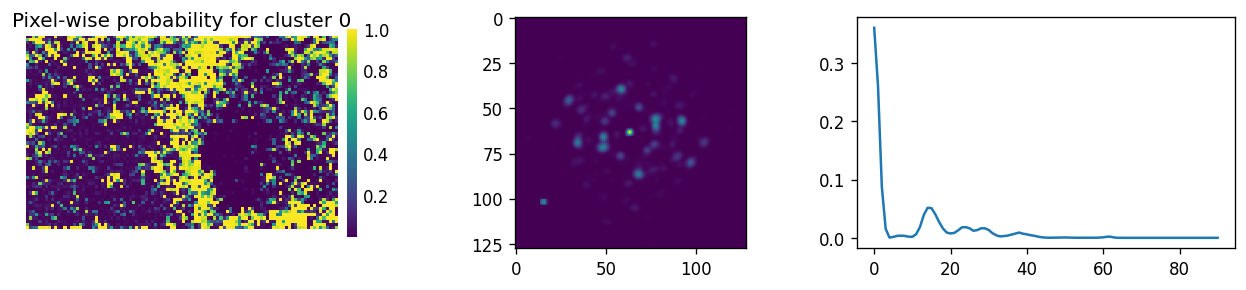

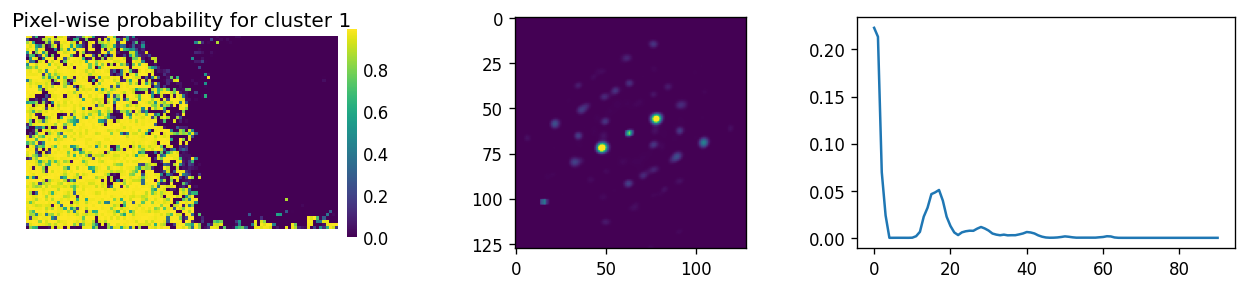

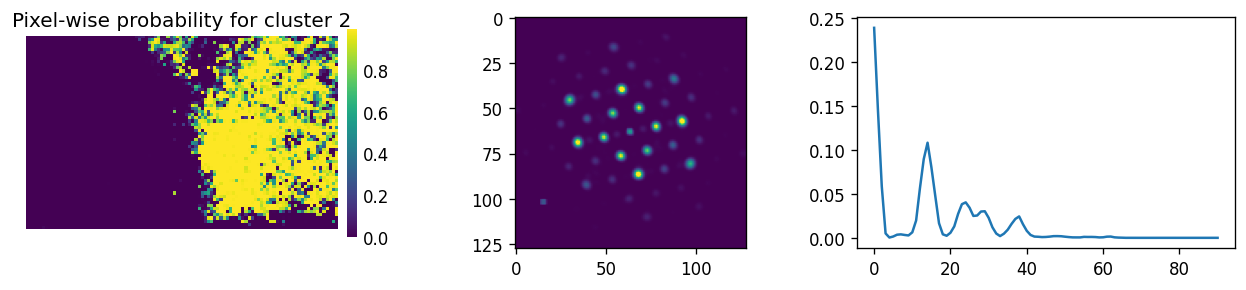

In [84]:
# ps.set_feature_list(['Al_Ka', 'C_Ka', 'Ca_Ka', 'Fe_Ka', 'K_Ka', 'O_Ka', 'Si_Ka', 'Ti_Ka', 'Zn_La'])
gui.show_cluster_distribution(ps=ps,spectra_range=(0,11))

### 3.3.3 Checking cluster map

In [85]:
# Plot phase map using the corresponding GM model
gui.view_phase_map(ps=ps, alpha_cluster_map=0.5)

Output()

**Parameters for `gui.view_clusters_sum_spectra`**<br>

> `ps`: *PixelSegmenter*. The object of PixelSegmetor which is just created.<br>

> `normalisation`: *bool*. If `True`, the sum spectra will be normalised.<br>

> `spectra_range`: *tuple*. Set the limits of the energy axes (in *KeV*).<br>

SelectMultiple(options=('cluster_0', 'cluster_1', 'cluster_2'), value=())

Output()

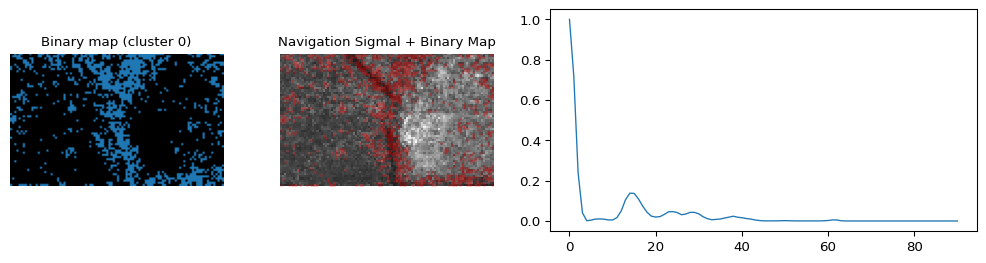

In [86]:
gui.view_clusters_sum_spectra(ps=ps, normalisation=True, spectra_range=(0,8))

# 4. Unmixing cluster spectrums using Non-negative Matrix Fatorization (NMF)

**Parameters for `gui.get_unmixed_edx_profile`**<br>
> `clusters_to_be_calculated`: *str* or *List*. If `'All'`, all cluster-spectra will be included in the data matrix for NMF. If it is a list of integers (e.g. [0,1,2,3]), only #0, #1, #2, and #3 cluster-spectra will be used as the data matrix for NMF.<br>

> `normalised`: *bool*. If `True`, the sum spectra will be normalised before NMF unmixing.<br>

> `method`: *str*. Model to be used.<br>

> `method_args`: *Dict*. Keyword arugments for the NMF method (or others). [See more detail here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html).<br>

In [16]:
weights, components = ps.get_unmixed_spectra_profile(clusters_to_be_calculated='All', 
                                                 n_components='All',
                                                 normalised=False, 
                                                 method='NMF', 
                                                 method_args={'init':'nndsvd'})

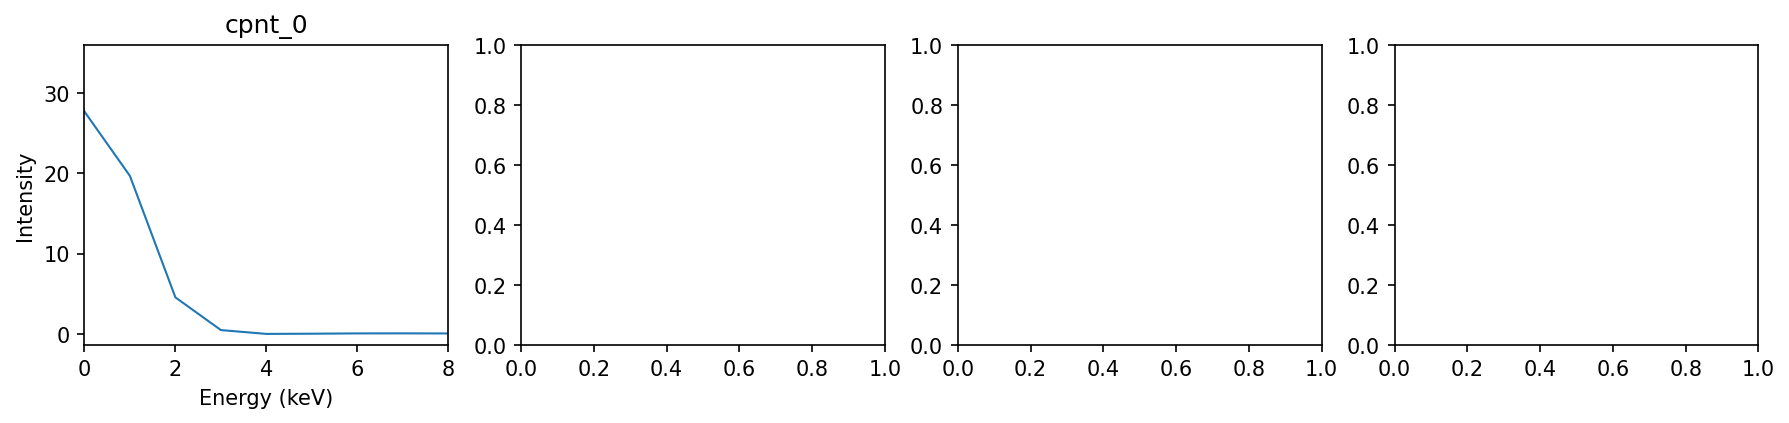

In [17]:
gui.show_unmixed_weights_and_compoments(ps=ps, weights=weights, components=components)

## Check abundance map for components (using RGB maps)

In [18]:
gui.show_abundance_map(ps=ps, weights=weights, components=components)

Output()

Output()

## Statistics infro from clusters

In [19]:
gui.show_cluster_stats(ps=ps)

Output()